### Plot gnn results vs cpsat results either with same runtime or with same quality

In [122]:
import json
import csv


# load results of gnn. change the paths to the files if you want to compare different data
gnn_file = "inference_vs_sgspostpro_20221103131842.json"
cpsat_file = "cpsat_solutions.csv"
with open(gnn_file) as json_file:
   gnn_data = {entry["benchmark_id"] : entry for entry in json.load(json_file).values()}

with open(cpsat_file) as csv_file:
   reader = csv.reader(csv_file, delimiter=",")
   cpsat_data = [row for row in reader]

In [123]:
def get_closest_result(gnn_result, cpsat_results, cpsat_feature_idx, gnn_feature_name):
   # change these columns if the benchmark id of the cpsat can be found in another column
   cpsat_id_col = (0, )
   benchmark_id = gnn_result["benchmark_id"]
   inference_time = gnn_result[gnn_feature_name]
   matching_cp_results = [res for res in cpsat_results if float(res[cpsat_id_col[0]]) == benchmark_id]
   if len(matching_cp_results) == 0:
      raise RuntimeError(f"no cpsat results found for benchmark id {benchmark_id}")

   closest_match = matching_cp_results[0]
   for res in matching_cp_results:
      current_diff = abs(float(res[cpsat_feature_idx]) - inference_time)
      if current_diff < abs(float(closest_match[cpsat_feature_idx]) - inference_time):
         closest_match = res

   return closest_match

In [124]:
import matplotlib.pyplot as plt
import numpy as np


def scatter_plot(x, y, xlabel, ylabel, title, log_scale = False):
   x_max = max(x)
   x_min = min(x)
   y_max = max(y)
   y_min = min(y)
   id_x = np.linspace(max(x_min, y_min), min(x_max, y_max), 100)
   plt.scatter(x, y)
   plt.plot(id_x, id_x)
   plt.xlabel(xlabel)
   plt.ylabel(ylabel)
   plt.title(title)
   if log_scale:
      plt.xscale('log')
      plt.yscale('log')

   plt.show()


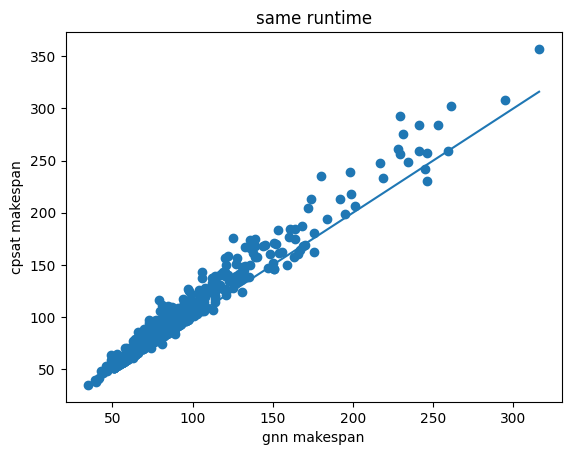

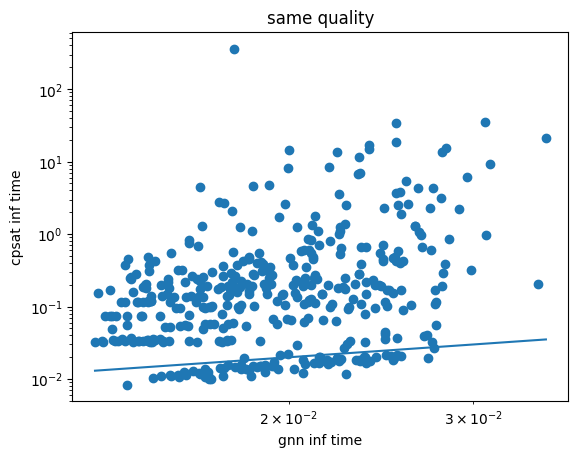

In [125]:
cpsat_inf_time_col = 1
cpsat_makespan_col = 3

gnn_results = [gnn_res["feasibility_abs_makespan"] for gnn_res in gnn_data.values()]
cpsat_baseline = [float(get_closest_result(gnn_res, cpsat_data, cpsat_inf_time_col, "inference_time")[cpsat_makespan_col]) for gnn_res in gnn_data.values()]
scatter_plot(gnn_results, cpsat_baseline, "gnn makespan", "cpsat makespan", "same runtime")

gnn_results = [gnn_res["inference_time"] for gnn_res in gnn_data.values()]
closest = [get_closest_result(gnn_res, cpsat_data, cpsat_makespan_col, "feasibility_abs_makespan") for gnn_res in gnn_data.values()]
gnn_makespans = [res["feasibility_abs_makespan"] for res in gnn_data.values()]
cpsat_baseline = [float(get_closest_result(gnn_res, cpsat_data, cpsat_makespan_col, "feasibility_abs_makespan")[cpsat_inf_time_col]) for gnn_res in gnn_data.values()]
scatter_plot(gnn_results, cpsat_baseline, "gnn inf time", "cpsat inf time", "same quality",  log_scale=True)
